# DAML 04 - Time Series

Michal Grochmal <michal.grochmal@city.ac.uk>

Working with data we find ourselves defining dimensions over which we want to analyze it
(aggregate it).  Dimension is a well known word in data warehousing and in analytic queries
over such warehouses.  One such dimension that always appear for data analysis is the
time dimension.  Windowing, changing granularity or aggregating over specific times in the
time dimension is called time series analysis.

Time series analysis requires us to be able to change the time dimension quickly, and tailor
it to our current needs with little computation overhead.  `pandas` provides the tools for this
through its time indexes: time stamps, time periods and time deltas.  Let's see how we build these.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 12

Python has the `datetime` object built into the standard library but it is quite limited.
There is also the [dateutil][] module, by Gustavo Niemeyer, which has a much better
date parser; and the [pytz][], by Stuart Bishop, which allows to localize times and dates
within and between timezones.  `pandas` makes use of all three of these modules to build its
`Timestamp`, `Period` and `Timedelta` objects.

[dateutil]: https://dateutil.readthedocs.io/en/stable/ "dateutil documentation"
[pytz]: http://pythonhosted.org/pytz/ "pytz documentation"

For example, the three dates below are parsed with the `dateutil` module behind the scenes.

In [2]:
pd.to_datetime('January, 2017'), pd.to_datetime('3rd of February 2016'), pd.to_datetime('6:31PM, Nov 11th, 2017')

(Timestamp('2017-01-01 00:00:00'),
 Timestamp('2016-02-03 00:00:00'),
 Timestamp('2017-11-11 18:31:00'))

Date operations, e.g. the common cross-language `strftime`,
work on `pandas` dates juts like on Python dates.

In [3]:
date = pd.to_datetime('3rd of January 2018')
date.strftime('%A')

'Wednesday'

Just like date operations, time deltas work too.
And broardcasting works on deltas too (that `'D'` means "day", see next).

In [4]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06',
               '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14'],
              dtype='datetime64[ns]', freq=None)

## Indexes on dates

We can distinguish between three time definitions:
the **timestamp**, e.g. at which time the plane did land;
the **time period**, e.g. how many planes did land this Wednesday;
and **time deltas** (or durations), e.g. how long ago did the last plane land.
Each of these has a `pandas` object and index type:

-   The `DatetimeIndex` is composed of `Timestamp` objects and is the most basic date index type.
-   `PeriodIndex` uses `Period` objects which contain `start_time` and `end_time`
    attributes to check whether a timestamp falls within the period.
-   And the `TimedeltaIndex` is composed of `Timedelta` objects, which represent a duration of time.

We can understand periods as aggregates of timestamps and are internally defined as a single
timestamp (start of period) and a frequency (duration of the period).  All periods within a
`PeriodIndex` must have the same frequency.  The frequency (or duration, or offset) in `pandas`
can be defined in many ways, with letter codes.  The most important ones are:

+ `D` - day
+ `B` - day, business days only
+ `W` - week
+ `M` - month
+ `A`/`Y` - year
+ `H` - hour
+ `T`/`min` - minute
+ `S` - second

And these can be combined in several ways
(e.g. `BAS-APR` mean a year starting on 1st of April as the first business day).
It is nearly impossible to remember all combinations,
do have a link to the [offset documentation][offset] handy.
Let's see how to create time based indexes:

[offset]: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases "frequency codes"

In [5]:
dates = pd.to_datetime(['3rd of January 2016', '2016-Jul-6', '20170708'])
dates

DatetimeIndex(['2016-01-03', '2016-07-06', '2017-07-08'], dtype='datetime64[ns]', freq=None)

Those are `Timestamps`, we can convert that to `Periods`.

In [6]:
dates.to_period('D')

PeriodIndex(['2016-01-03', '2016-07-06', '2017-07-08'], dtype='period[D]', freq='D')

And operations between dates result in `Timedelta`s.

In [7]:
dates - dates[0]

TimedeltaIndex(['0 days', '185 days', '552 days'], dtype='timedelta64[ns]', freq=None)

Instead of writing all dates we want in an index we can (and should) use the `_range` methods.

In [8]:
pd.date_range('2017-11-29', '2017-12-03')

DatetimeIndex(['2017-11-29', '2017-11-30', '2017-12-01', '2017-12-02',
               '2017-12-03'],
              dtype='datetime64[ns]', freq='D')

In [9]:
pd.date_range('2017-12-03', periods=6)

DatetimeIndex(['2017-12-03', '2017-12-04', '2017-12-05', '2017-12-06',
               '2017-12-07', '2017-12-08'],
              dtype='datetime64[ns]', freq='D')

In [10]:
pd.date_range('2017-12-03', periods=10, freq='H')

DatetimeIndex(['2017-12-03 00:00:00', '2017-12-03 01:00:00',
               '2017-12-03 02:00:00', '2017-12-03 03:00:00',
               '2017-12-03 04:00:00', '2017-12-03 05:00:00',
               '2017-12-03 06:00:00', '2017-12-03 07:00:00',
               '2017-12-03 08:00:00', '2017-12-03 09:00:00'],
              dtype='datetime64[ns]', freq='H')

In [11]:
pd.period_range('2017-09', periods=8, freq='M')

PeriodIndex(['2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
             '2018-03', '2018-04'],
            dtype='period[M]', freq='M')

In [12]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

## Fremont Bridge

The [Fremont bridge][fremont] in Seattle is possibly on of the most studied bridges in the world,
it sits between the Google office in Seattle and the Adobe offices.  It is preferred by cyclists
due to the fact that it is a small bridge linking north Seattle and downtown (the other two bridges
are motorway bridges).  Bicycle counters were installed on both sides of the bridge in 2012, and
are collecting data to this day (as of time of writing).

The data can be downloaded from  <http://data.seattle.gov/> ([direct link][dataset]) but we
can use the `fremont-bridge.csv` file I have already downloaded.  The file has a `Date` column
which we will parse as the index of our time series.  Then we will try to get an understanding
of the data (e.g. using `describe`) and see if we can plot something interesting.

A huge analysis of this data was performed by Jake VanderPlas in his blog.
See the references at the end, his analysis goes much further than we go here.

[fremont]: http://www.openstreetmap.org/#map=17/47.64813/-122.34965
[dataset]: https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k).

In [13]:
data = pd.read_csv('../data/fremont-bridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


That looks good but the column names are slightly long.
Let's reduce column names and add a "Total" column for all bikes crossings.

In [14]:
data.columns = ['West', 'East']
data['Total'] = data['West'] + data['East']
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


Better, now we can looks at some statistics.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45984 entries, 2012-10-03 00:00:00 to 2017-12-31 23:00:00
Data columns (total 3 columns):
West     45976 non-null float64
East     45976 non-null float64
Total    45976 non-null float64
dtypes: float64(3)
memory usage: 1.4 MB


In [16]:
data.describe()

,West,East,Total
count,45976.000000,45976.000000,45976.000000
mean,54.712306,55.479315,110.191622
std,72.935797,80.232055,139.189603
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,60.000000
75%,72.000000,68.000000,144.000000
max,854.000000,717.000000,1165.000000


The data is aggregated by the hour, something that will be important to keep in mind.
There is a handful of NaNs too but these are few and probably negligible.

We should plot it to get a better understanding.
We will need `matplotlib` configuration.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

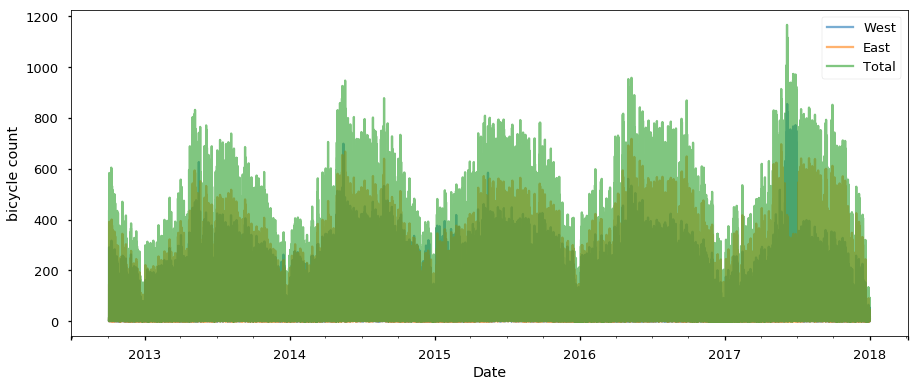

In [18]:
plot = data.plot(alpha=0.6, figsize=(15, 6))
plot.set_ylabel('bicycle count');

The data is too granular.
We can see an annual trend in there but it is difficult to say much more.
If we aggregate the bicycle count by week we should see more.

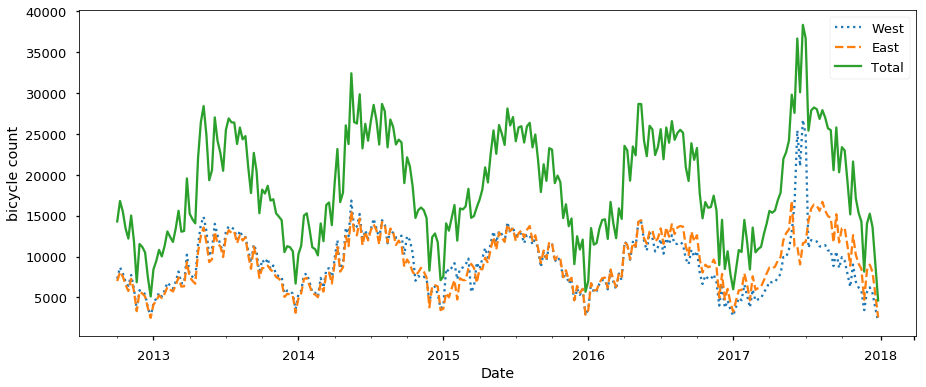

In [19]:
weekly = data.resample('W').sum()
plot = weekly.plot(style=[':', '--', '-'], figsize=(15, 6))
plot.set_ylabel('bicycle count');

Still very rigged, perhaps a rolling window over 30 days would be better.

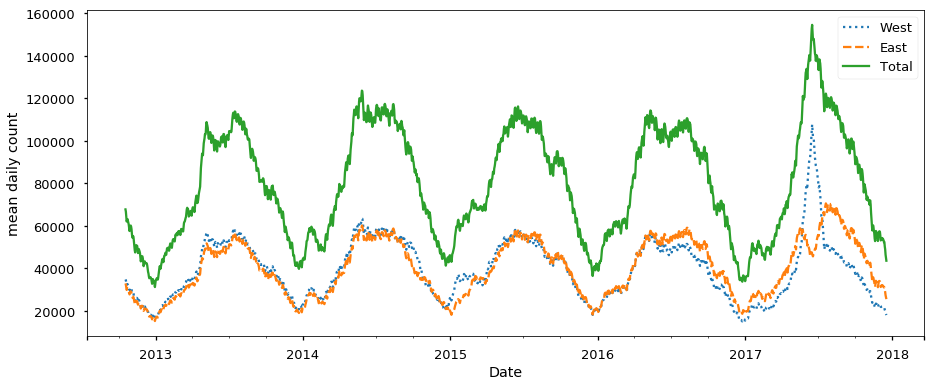

In [20]:
daily = data.resample('D').sum()
plot = daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'], figsize=(15, 6))
plot.set_ylabel('mean daily count');

That's good enough.  The rolling window flattens the noise.
The only thing we could improve towards a presentation of the graph is the number of points.
Above every day is still a single point on the graph,
we could smoothen it by making a window over 5 weeks instead of 30 days.
For an even smoother curve we could do a rolling window over 10 weeks.

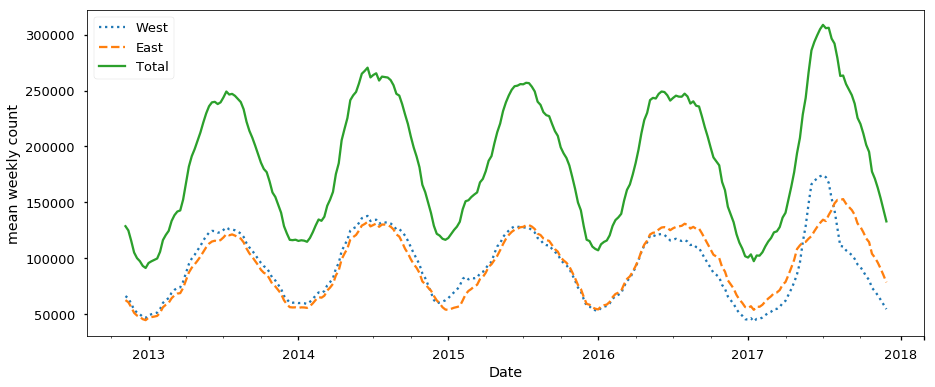

In [21]:
weekly = data.resample('W').sum()
plot = weekly.rolling(10, center=True).sum().plot(style=[':', '--', '-'], figsize=(15, 6))
plot.set_ylabel('mean weekly count');

### Group By

Similar to an RDBMS we can group by directly on the pandas data frame.
On a time series *grouping by* can produce completely different time frames,
known as dicing and slicing the frame.  In general we want to *group by* to
first filter all rows into smaller groups and then apply the aggregation
to each of these smaller groups.

On dates and times this division is quite evident: each day is formed of hours,
each hour of minutes and so on.  Let's first try to get a series of time stamps
from our data and see how we can divide it into divisions such as weeks, days
or hours.

In [22]:
series = data.index.to_series()
series

Date
2012-10-03 00:00:00   2012-10-03 00:00:00
2012-10-03 01:00:00   2012-10-03 01:00:00
2012-10-03 02:00:00   2012-10-03 02:00:00
2012-10-03 03:00:00   2012-10-03 03:00:00
2012-10-03 04:00:00   2012-10-03 04:00:00
2012-10-03 05:00:00   2012-10-03 05:00:00
                              ...        
2017-12-31 18:00:00   2017-12-31 18:00:00
2017-12-31 19:00:00   2017-12-31 19:00:00
2017-12-31 20:00:00   2017-12-31 20:00:00
2017-12-31 21:00:00   2017-12-31 21:00:00
2017-12-31 22:00:00   2017-12-31 22:00:00
2017-12-31 23:00:00   2017-12-31 23:00:00
Name: Date, Length: 45984, dtype: datetime64[ns]

The date and time properties of the `Series` are on an attribute called `dt`.
This attribute has [several properties][properties] that can be used to aggregate over.

[properties]: http://pandas.pydata.org/pandas-docs/version/0.20/api.html#datetimelike-properties

In [23]:
series.dt.dayofyear

Date
2012-10-03 00:00:00    277
2012-10-03 01:00:00    277
2012-10-03 02:00:00    277
2012-10-03 03:00:00    277
2012-10-03 04:00:00    277
2012-10-03 05:00:00    277
                      ... 
2017-12-31 18:00:00    365
2017-12-31 19:00:00    365
2017-12-31 20:00:00    365
2017-12-31 21:00:00    365
2017-12-31 22:00:00    365
2017-12-31 23:00:00    365
Name: Date, Length: 45984, dtype: int64

In [24]:
series.dt.dayofweek

Date
2012-10-03 00:00:00    2
2012-10-03 01:00:00    2
2012-10-03 02:00:00    2
2012-10-03 03:00:00    2
2012-10-03 04:00:00    2
2012-10-03 05:00:00    2
                      ..
2017-12-31 18:00:00    6
2017-12-31 19:00:00    6
2017-12-31 20:00:00    6
2017-12-31 21:00:00    6
2017-12-31 22:00:00    6
2017-12-31 23:00:00    6
Name: Date, Length: 45984, dtype: int64

So let's try out this *grouping by*.
How many data points (hours) we have within each day of the week.

In [25]:
series.groupby(series.dt.dayofweek).count()

Date
0    6552
1    6552
2    6576
3    6576
4    6576
5    6576
6    6576
Name: Date, dtype: int64

How many hours within each year.

In [26]:
series.groupby(series.dt.year).count()

Date
2012    2160
2013    8760
2014    8760
2015    8760
2016    8784
2017    8760
Name: Date, dtype: int64

The hours within each of the days of the week but for 2012 only.

In [27]:
series2012 = series['2012']
series2012.groupby(series2012.dt.dayofweek).count()

Date
0    312
1    288
2    312
3    312
4    312
5    312
6    312
Name: Date, dtype: int64

OK, data collection started on a Wednesday so we do not have data for the first Monday and Tuesday.
2012 ended in a Monday 31st of December, so we can see that there is an extra Monday in there.  2016
was a leap year so we get 24 hours (and 24 data points more).

But finding the missing data (remember the `data.info` above) from the `Series` is not going to be possible.
This is because the series uses the index which is complete.  Yet, finding the missing data from
the actual data frame is pretty easy.

In [28]:
data[(data['West'].isnull()) | (data['East'].isnull())]

,West,East,Total
Date,,,
2013-06-14 09:00:00,NaN,NaN,NaN
2013-06-14 10:00:00,NaN,NaN,NaN
2014-03-09 02:00:00,NaN,NaN,NaN
2015-03-08 02:00:00,NaN,NaN,NaN
2015-04-21 11:00:00,NaN,NaN,NaN
2015-04-21 12:00:00,NaN,NaN,NaN
2016-03-13 02:00:00,NaN,NaN,NaN
2017-03-12 02:00:00,NaN,NaN,NaN


That's actually pretty random.  Device malfunction perhaps?  I'll argue that we can safely ignore
these missing points and go back to our full datatset.

Knowing about grouping by we can slice the data in more ways now.  One thing to note is that several
of the properties of the `Series.dt` object are directly available from a `DatetimeIndex`.
For example, grouping by time (we only have hours) we can get the mean hourly traffic.

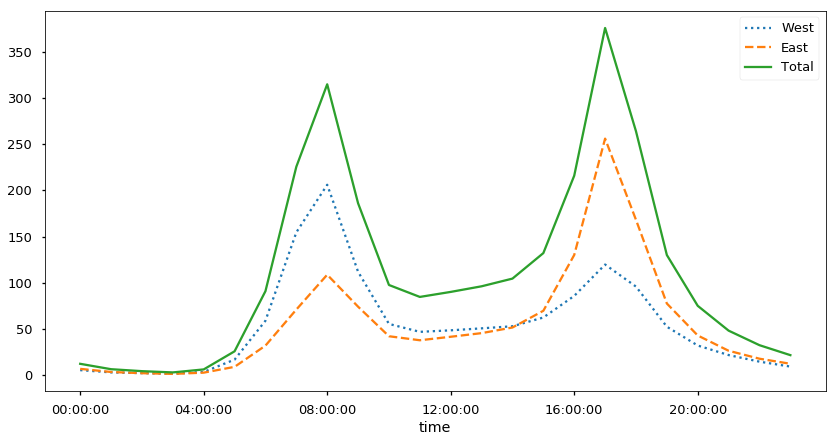

In [29]:
by_time = data.groupby(data.index.time).mean()
# where we want the ticks, do not let matplotlib choose
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'], figsize=(14, 7));

Well, yeah, those are people cycling to work and cycling back home.

Grouping by the day of the week we get the amount of traffic across weekdays.

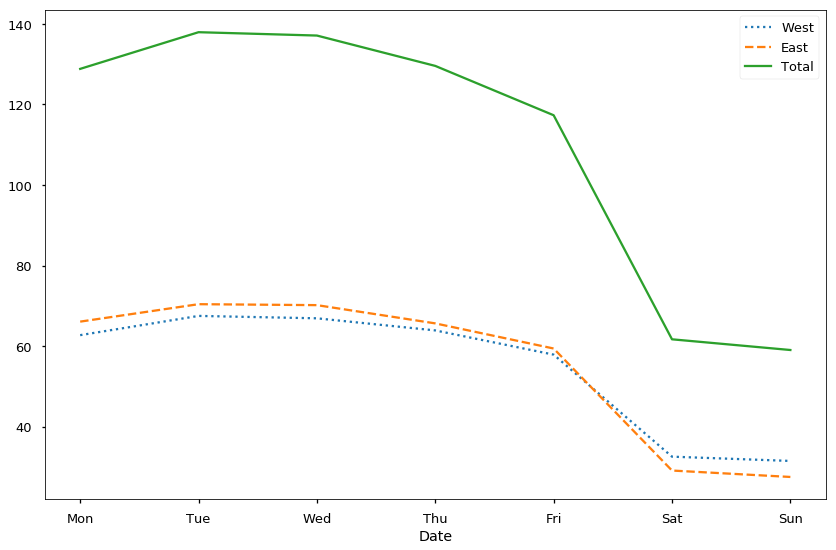

In [30]:
by_weekday = data.groupby(data.index.dayofweek).mean()
# this is - again - a trick to get nice ticks
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot = by_weekday.plot(xticks=np.arange(len(weekdays)), style=[':', '--', '-'], figsize=(14, 9))
plot.set_xticklabels(weekdays);

The weekend is very different, as we'd expect.
We can also check how the hourly distribution is on the weekend.
We build a multi-index by *grouping by* over two elements.

In [31]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()
by_time

West       East      Total
Weekday 00:00:00   4.739766   5.752193  10.491959
        01:00:00   2.449561   2.702485   5.152047
        02:00:00   1.827485   1.667398   3.494883
        03:00:00   1.458333   1.250731   2.709064
        04:00:00   4.187865   2.997076   7.184942
        05:00:00  21.797515  11.308480  33.105994
...                     ...        ...        ...
Weekend 18:00:00  42.824818  38.441606  81.266423
        19:00:00  28.423358  27.204380  55.627737
        20:00:00  20.096715  20.777372  40.874088
        21:00:00  14.195255  15.375912  29.571168
        22:00:00  10.510949  12.496350  23.007299
        23:00:00   7.872263  10.375912  18.248175

[48 rows x 3 columns]

Now one can select from the first index and plot each piece of data side to side.
(Or one below the other, as here.)

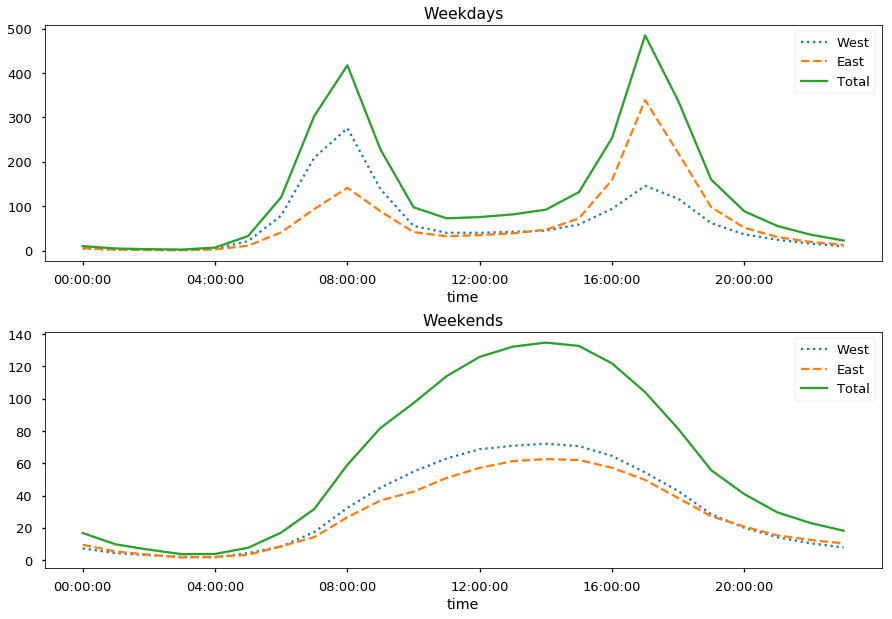

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                            xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                            xticks=hourly_ticks, style=[':', '--', '-']);

## References and Extras

* [Python Data Science Handbook - Chapter 3: Pandas - Working with time series - Jake VanderPlas][1]
* [Is Seattle Really Seeing an Uptick In Cycling? - Jake VanderPlas][2]

[1]: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
[2]: https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/